In [1]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn
import optax
import scipy
import matplotlib.pyplot as plt
pi = jnp.pi

In [2]:
# We create one dense layer instance (taking 'features' parameter as input)

class ExplicitMLP(nn.Module):
    features: Sequence[int]
    lb = jnp.array([0.0,-1.0])
    ub = jnp.array([1.0,1.0])

    def setup(self):
    # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

    def __call__(self, inputs,lb=lb,ub=ub):
       # print(ub,lb)
        x = 2.0*(inputs-lb)/(ub-lb) - 1.0
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.tanh(x)
        return x
#model = nn.Dense(features=5)

In [3]:
model =  ExplicitMLP(features=[20,20,20,20,20,20,20,20,1])
key, key1 = random.split(random.PRNGKey(0))
x = random.normal(key1, (1,2)) # Dummy input data
key, key1 = random.split(key)
params = model.init(key1,x)

In [4]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'layers_0': {'bias': (20,), 'kernel': (2, 20)},
  'layers_1': {'bias': (20,), 'kernel': (20, 20)},
  'layers_2': {'bias': (20,), 'kernel': (20, 20)},
  'layers_3': {'bias': (20,), 'kernel': (20, 20)},
  'layers_4': {'bias': (20,), 'kernel': (20, 20)},
  'layers_5': {'bias': (20,), 'kernel': (20, 20)},
  'layers_6': {'bias': (20,), 'kernel': (20, 20)},
  'layers_7': {'bias': (20,), 'kernel': (20, 20)},
  'layers_8': {'bias': (1,), 'kernel': (20, 1)}}}

In [5]:
def get_bndry_random(key,x_min=-1.0,x_max=1.0,xn=100,t_min=0.0,t_max=1.0,tn=100):
    key1,key = jax.random.split(key)
    x = jax.random.uniform(key1,shape=(xn,),minval=x_min,maxval=x_max)
    t = t_min*jnp.ones_like(x)
    d_ini = jnp.stack((t,x),axis=1)
    
    
    
    f_ini = -jnp.sin(pi*x)
    
    
    key1,key = jax.random.split(key)
    t = jax.random.uniform(key1,shape=(tn,),minval=t_min,maxval=t_max)
    bnl = 1.0*jax.random.bernoulli(key, p=0.5, shape=t.shape)
    xb  = x_min*bnl + x_max*(1.0-bnl)
   
    
    f_b = jnp.zeros_like(xb)
    
    d_b = jnp.stack((t,xb),axis=1)
 
    
    d = jnp.concatenate((d_ini,d_b),axis=0)
    f = jnp.concatenate((f_ini,f_b),axis=0)
    
    
    print("d_ini shape ",d_ini.shape,f_ini.shape)
    print("d_b shape ",d_b.shape,f_b.shape)
    print("d ",d.shape,f.shape)
    
    return d,f

def get_bndry(x_min=-1.0,x_max=1.0,xn=100,t_min=0.0,t_max=1.0,tn=100):
    x = jnp.linspace(x_min,x_max,xn)
    t = t_min*jnp.ones_like(x)
    d_ini = jnp.stack((t,x),axis=1)
    
    xnh = int(1.0*xn/2.0)
    
    f_ini = -jnp.sin(pi*x)
    
    t = jnp.linspace(t_min,t_max,tn)
    xl = -1.0*jnp.ones_like(t)
    xr = 1.0*jnp.ones_like(t)
    
    f_l = jnp.zeros_like(xl)
    
    d_bl = jnp.stack((t,xl),axis=1)
    d_br = jnp.stack((t,xr),axis=1)
    
    d = jnp.concatenate((d_ini,d_bl,d_br),axis=0)
    f = jnp.concatenate((f_ini,f_l,f_l),axis=0)
    
    
    print("d_ini shape ",d_ini.shape,f_ini.shape)
    print("d_l shape ",d_bl.shape,f_l.shape)
    print("d ",d.shape,f.shape)
    
    return d,f

def get_domain_points(key,x_min=-1.0,x_max=1.0,t_min=0.0,t_max=1.0,n=100):
    t = random.uniform(key,[n],minval=t_min,maxval=t_max)
    key1,key = jax.random.split(key)
    x = random.uniform(key1,[n],minval=x_min,maxval=x_max)
    
    return t,x

def get_domain_points_lhs(x_min=-1.0,x_max=1.0,t_min=0.0,t_max=1.0,n=100):
    
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n)
    l_bounds = [t_min,x_min]
    u_bounds = [t_max,x_max]
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    t = 1.0*sample_scaled[:,0]
    x = 1.0*sample_scaled[:,1]
    
    
    t = jnp.array(t)
    x = jnp.array(x)
    
    return t,x
    
    


In [6]:
#t,x = get_domain_points(key2,n=2000)
key, key1 = random.split(key)
t,x = get_domain_points_lhs(n=10000)
bndry,f_bndry = get_bndry_random(key1,xn=100,tn=50)
dom = jnp.stack((t,x),axis=1)
print(t.shape,x.shape,bndry.shape,f_bndry.shape,dom.shape)
#plt.plot(bndry[50:150,1])

d_ini shape  (100, 2) (100,)
d_b shape  (50, 2) (50,)
d  (150, 2) (150,)
(10000,) (10000,) (150, 2) (150,) (10000, 2)


In [7]:
@jax.jit
def Burgers(params,t,x):
    def pred(params,t,x):
        out_e = jnp.eye(1,1,0).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    

    dx_pred = jax.grad(pred,argnums=2)
    dxx_pred = jax.grad(dx_pred,argnums=2)
    dt_pred = jax.grad(pred,argnums=1)
    
    
    
    eqn = dt_pred(params,t,x) + pred(params,t,x)*dx_pred(params,t,x)-(0.01/jnp.pi)*dxx_pred(params,t,x)
    
    return jnp.inner(eqn,eqn)/2.0




Burgers(params,0.9,1.8)

Array(0.27567914, dtype=float32)

In [9]:
#k1,k2 = jax.random.split(key2)
#x_samples = random.normal(k1,(n_samp,xdim))
#f_samples = jnp.sin(x_samples[:,1]-x_samples[:,0])

In [8]:
@jax.jit
def mse(params,bndry,f_bndry,td,xd):
    
    def sq_loss(x,y):
        yp = model.apply(params,x)
        return jnp.inner((y-yp),(y-yp))/2.0
    def apply_diff_eq(t,x):
        return Burgers(params,t,x)
    
    return jnp.mean(jax.vmap(sq_loss)(bndry,f_bndry),axis=0) + jnp.mean(jax.vmap(apply_diff_eq,in_axes=(0,0))(td,xd),axis=0)
        
    

In [9]:
print("loss is {}",mse(params,bndry,f_bndry,t,x))

loss is {} 0.43601534


In [10]:
loss_and_grad = jax.value_and_grad(mse)

In [13]:
#@jax.jit
#def update_params(params,grads,lr=0.1):
#    param_u = jax.tree_util.tree_map(lambda p,g: p-lr*g,params,grads)
#    return param_u

In [14]:
#for i in range(10001):
#    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
#    params = update_params(params,grd)
#    if i%10==0:
#        print(f"loss is {i}",loss)

In [11]:

tx = optax.adam(learning_rate=0.001)
optstate = tx.init(params) 

In [12]:
loss_min =1.0
for i in range(5000):
    #t,x=get_domain_points(key2,n=100)
    #key1,key2 = random.split(key2)
    loss,grd = loss_and_grad(params,bndry,f_bndry,t,x)
    if loss_min>loss:
        params_best = params
        loss_min = loss
    updates,optstate = tx.update(grd,optstate)
    params = optax.apply_updates(params,updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss)
        
print("best loss ",loss_min)

Loss step 0:  0.4360153
Loss step 10:  0.13314573
Loss step 20:  0.11051486
Loss step 30:  0.09853344
Loss step 40:  0.09207616
Loss step 50:  0.0875756
Loss step 60:  0.0836598
Loss step 70:  0.08001579
Loss step 80:  0.076668106
Loss step 90:  0.07380359
Loss step 100:  0.07166349
Loss step 110:  0.07014009
Loss step 120:  0.06891488
Loss step 130:  0.067729615
Loss step 140:  0.06648678
Loss step 150:  0.06518245
Loss step 160:  0.06382604
Loss step 170:  0.062416967
Loss step 180:  0.06095107
Loss step 190:  0.05942504
Loss step 200:  0.057834666
Loss step 210:  0.05617549
Loss step 220:  0.054442152
Loss step 230:  0.05262816
Loss step 240:  0.050738446
Loss step 250:  0.048813123
Loss step 260:  0.04693793
Loss step 270:  0.045215253
Loss step 280:  0.043719396
Loss step 290:  0.042471975
Loss step 300:  0.041438065
Loss step 310:  0.04055498
Loss step 320:  0.03976914
Loss step 330:  0.039048575
Loss step 340:  0.0383784
Loss step 350:  0.0377524
Loss step 360:  0.03716737
Loss 

Loss step 2860:  0.0014902047
Loss step 2870:  0.0018591514
Loss step 2880:  0.0013449922
Loss step 2890:  0.0012226839
Loss step 2900:  0.0012035199
Loss step 2910:  0.0011813418
Loss step 2920:  0.0011622617
Loss step 2930:  0.0011473736
Loss step 2940:  0.0011348991
Loss step 2950:  0.0011238039
Loss step 2960:  0.0011135276
Loss step 2970:  0.0011037284
Loss step 2980:  0.0010942883
Loss step 2990:  0.0010851886
Loss step 3000:  0.0010763739
Loss step 3010:  0.00106781
Loss step 3020:  0.0010594733
Loss step 3030:  0.0010513376
Loss step 3040:  0.0010433896
Loss step 3050:  0.0010356136
Loss step 3060:  0.001027993
Loss step 3070:  0.0010205201
Loss step 3080:  0.001013186
Loss step 3090:  0.0010059808
Loss step 3100:  0.0009988968
Loss step 3110:  0.0009919287
Loss step 3120:  0.0009850702
Loss step 3130:  0.0009783136
Loss step 3140:  0.0009716558
Loss step 3150:  0.0009650942
Loss step 3160:  0.0009586224
Loss step 3170:  0.0009522348
Loss step 3180:  0.0009459324
Loss step 3190

(200, 2)


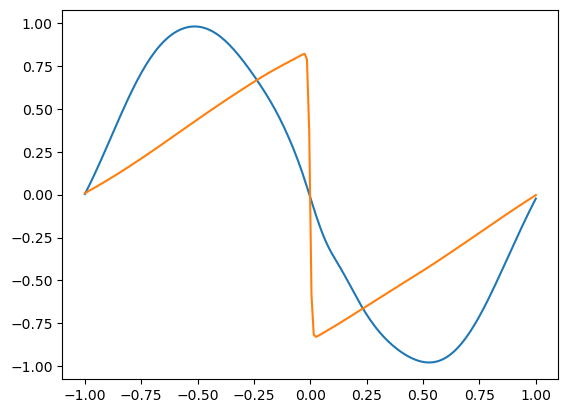

In [13]:
key,key1= random.split(key)
xx = jnp.linspace(-1.0,1.0,200)
tt=0.0
dmn = jnp.stack((tt*jnp.ones_like(xx),xx),axis=1)
dmn2 = jnp.stack((0.8*jnp.ones_like(xx),xx),axis=1)
print(dmn.shape)
f = model.apply(params_best,dmn)
f2 = model.apply(params_best,dmn2)
plt.plot(xx,f,label="ini")
plt.plot(xx,f2,label="t=0.8")
#dmn

In [ ]:
#################### Using CLASS PINNs  #########################

In [ ]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn
import optax
import scipy
import matplotlib.pyplot as plt
pi = jnp.pi

In [ ]:
key, key1 = random.split(random.PRNGKey(0))

In [ ]:
#t,x = get_domain_points(key2,n=2000)
key, key1 = random.split(key)
t,x = get_domain_points_lhs(n=10000)
bndry,f_bndry = get_bndry_random(key1,xn=100,tn=50)
dom = jnp.stack((t,x),axis=1)
print(t.shape,x.shape,bndry.shape,f_bndry.shape,dom.shape)
#plt.plot(bndry[50:150,1])

In [8]:

import PINNs

In [9]:
dom_bnds = ([0.0,-1.0],[1.0,1.0])
print(len(dom_bnds[0]))
Beq = PINNs.PINN(dom_bnds,[0.01/jnp.pi])

2
Prob coef 0.003183099
Bounds [ 0. -1.] [1. 1.]


In [13]:
key,key1= random.split(key)

Beq.model = Beq.make_model(8,20)
optim = optax.adam(learning_rate=0.001)
Beq.ready_model(key1,optim)
key,key1= random.split(key)

In [14]:
params_best,loss_min = Beq.batch_train(dom,bndry,f_bndry,epochs=2000,batch_n=32)

4 32
It 00000: loss = 1.87021881e-01
It 00050: loss = 5.60246967e-02
It 00100: loss = 3.65494937e-02
It 00150: loss = 2.72886287e-02
It 00200: loss = 2.38176025e-02
It 00250: loss = 2.14821137e-02
It 00300: loss = 1.87531877e-02
It 00350: loss = 1.16888331e-02
It 00400: loss = 7.66694453e-03
It 00450: loss = 3.90743930e-03
It 00500: loss = 2.18897546e-03
It 00550: loss = 1.50371122e-03
It 00600: loss = 2.90565216e-03
It 00650: loss = 1.52917206e-03
It 00700: loss = 9.83633101e-04
It 00750: loss = 6.03693828e-04
It 00800: loss = 5.05869626e-04
It 00850: loss = 4.45630838e-04
It 00900: loss = 3.49269307e-04
It 00950: loss = 2.93337274e-04
It 01000: loss = 2.40572277e-04
It 01050: loss = 2.60241097e-04
It 01100: loss = 3.35008197e-04
It 01150: loss = 6.68728026e-04
It 01200: loss = 1.07141677e-03
It 01250: loss = 2.72346544e-04
It 01300: loss = 2.07489298e-04
It 01350: loss = 6.15402649e-04
It 01400: loss = 1.92726875e-04
It 01450: loss = 7.02843419e-04
It 01500: loss = 9.63657920e-04
It 

(200, 2)


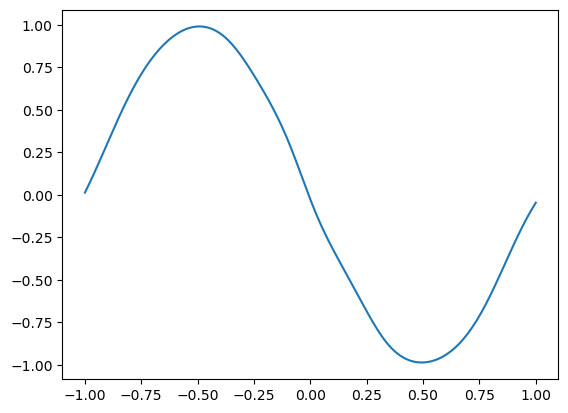

In [15]:

key,key1= random.split(key)
xx = jnp.linspace(-1.0,1.0,200)
tt=0.0
dmn = jnp.stack((tt*jnp.ones_like(xx),xx),axis=1)
print(dmn.shape)
f = model.apply(params_best,dmn)
plt.plot(xx,f)
#dmn

In [ ]:
#####################################  Miscellaneous stuff ############################################

In [ ]:
@jax.jit
def D_x(params,xin):
    argn = 1
    t = xin[:,0]
    x = xin[:,1]
    def pred(params,t,x):
        out_e = jnp.eye(1,1,0).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    
    d_pred = jax.grad(pred,argnums=argn)
    return jax.vmap(d_pred,in_axes=(None,0,0))(params,t,x)


def D2_tx(d_in_i,d_out_i=0,xdim=2,fdim=1):
    argn = d_in_i+1
    def pred(params,t,x):
        out_e = jnp.eye(1,fdim,d_out_i).flatten()
        xx = jnp.eye(1,2,0)*t + jnp.eye(1,2,1)*x
        f = model.apply(params,xx).flatten()
        return jnp.inner(f,out_e)
    
    d_pred = jax.grad(jax.grad(pred,argnums=argn),argnums=argn)
    return jax.vmap(d_pred,in_axes=(None,0,0))

  

In [ ]:
@jax.jit
def mse(params,x_batch,y_batch):
    def sq_loss(x,y):
        yp = model.apply(params,x)
        return jnp.inner((y-yp),(y-yp))/2.0
    
    return jnp.mean(jax.vmap(sq_loss)(x_batch,y_batch),axis=0)
        